## EKF Localisation using UTIAS dataset with known correlation

### Importing packages and other helper files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from helper_functions import *
from IPython import display

### Defining constants for the simulation

In [2]:
deltaT = 0.02; 

#robot-dependent motion noise parameters, see equation 3
alphas = [0.2, 0.03, 0.09, 0.08, 0, 0];  

#robot-dependent sensor noise parameters, see equation 9
sigma_range = 2;
sigma_bearing = 3;
sigma_id = 1;
initial_measurement_variance = 0.01  #very

Q_t = np.array([
        [sigma_range**2, 0, 0],
        [0, sigma_bearing**2, 0],
        [0, 0, sigma_id**2]
        ])

measurement_prob = 0;
n_robots = 1;
robot_num = 1;

#from Andre Kramer's script
r_robot = 0.165;
r_landmark = 0.055;

### Load and resample raw data from UTIAS data set

In [3]:
#The robot's position groundtruth, odometry, and measurements are stored in Robots
Barcodes, Landmark_Groundtruth, Robots = load_MRCLAM_dataSet();
Barcodes = Barcodes.astype(int)
codedict = dict(np.column_stack((Barcodes[:,1], Barcodes[:,0])))

Loading data
Reading robot1_Groundtruth data
Reading robot1_odometry data
Reading robot1_measurements data
Robot1 data read successfully
------------------------------------------------
All data successfully read
------------------------------------------------


In [4]:
Robots, timesteps = sample_MRCLAM_dataSet(Robots, deltaT)

### Reading Matlab reference output

In [5]:
matlab_op_file = 'localization/test.dat'
matlab_op_data = np.loadtxt(matlab_op_file)

### Initialise estimated parameters to zeros

In [6]:
def initialise_filter(Robots, robot_num=1, start = 600):
    
    # initialize time, and pose estimate
    Robots[str(robot_num)]['Est'] = np.zeros((Robots[str(robot_num)]['G'].shape[0], 4))

    # start index is set to 600 because earlier data was found to cause problems
    start = start -1 #due to python indexing

    # set start time
    t = Robots[str(robot_num)]['G'][start, 0]

    # set starting pose mean to pose groundtruth at start time
    poseMean = Robots[str(robot_num)]['G'][start,1:4].reshape(3,1)
    poseCov = np.ones((3,3)) *  initial_measurement_variance

    #tracks which measurement is next received
    #iterating to measurement index which time corresponds to 
    measurementIndex = 0;

    #advance measurement index until the next measurement time is greater than the starting time
    while (Robots[str(robot_num)]['M'][measurementIndex, 0] < (t - 0.05)):
            measurementIndex = measurementIndex + 1;
    return Robots, poseMean, poseCov, measurementIndex, start

### Set plotting parameters for visualising output

In [7]:
plot_options = {}
plot_options['plot_filter_op'] = True 
plot_options['refresh_rate'] = 5.0 #time in seoconds ideal to keep in range(0.5 - 5.0)
plot_options['Grid_on'] = True
plot_options['plot_GT'] = True 
plot_options['plot_Est'] = True 
plot_options['cov_ellipse'] = True
plot_options['plot_Landmarks'] = True 
plot_options['plot_matlab_op'] = True 

### Run filter for input Odometry and Lidar data

In [8]:
#loop through all odometry and measurement samples
#updating the robot's pose estimate with each step
#reference table 7.2 in Probabilistic Robotics

def run_filter(Robots, matlab_op_data, robot_num, plot_options):
    Robots, poseMean, poseCov, measurementIndex, start = initialise_filter(Robots, robot_num=1, start = 600)
    tgt_bot = Robots[str(robot_num)]
    
    if plot_options['plot_filter_op'] == True:
        #find the interval in which to plot filter outputs
        step_size = int(plot_options['refresh_rate'] / deltaT)
        
        if plot_options['plot_GT'] == True:
            print('Plotting GT trajectory')
            plot_gt_traj = True
        else:
            print('Cannot find GT trajectory, exiting function')
    
        #check if est traj is to be plotted    
        plot_est_traj = ('Est' in tgt_bot) and (plot_options['plot_Est'] == True)
        if plot_est_traj == True:
            print('Plotting estimated trajectory')
        else:
            print('Cannot plot estimated trajectory')

        #initiate plot variables and functions    
        plt.figure(figsize=(18,12))
        plt.axis('equal')
        xmin, xmax = tgt_bot['G'][:,1].min(), tgt_bot['G'][:,1].max()
        ymin, ymax = tgt_bot['G'][:,2].min(), tgt_bot['G'][:,2].max()
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
        
        if plot_options['Grid_on']:
            plt.grid(True)
                        
    for i in range(start, tgt_bot['G'].shape[0]):
        
        if i % 10000 ==0:
            print(str(i) + 'th iteration done')

        theta = poseMean[2, 0];

        #update time
        t = tgt_bot['G'][i,0]

        #update movement vector per equation 1
        u_t = np.array([tgt_bot['O'][i,1], tgt_bot['O'][i,2]])

        rot = deltaT * u_t[1];
        halfRot = rot / 2;
        trans = u_t[0] * deltaT;

        """
        #######   Motion update step      #######
        """
        
        #calculate the movement Jacobian per equation 2
        G_t = np.array([
                        [1, 0, trans * -np.sin(theta + halfRot)],
                        [0, 1, trans *  np.cos(theta + halfRot)],
                        [0, 0, 1]
                        ])

        #calculate motion covariance in control space per equation 3
        M_t = np.array([
                        [(alphas[0] * abs(u_t[0]) + alphas[1] * abs(u_t[1]))**2, 0],
                        [0, (alphas[2] * abs(u_t[1]) + alphas[3] * abs(u_t[1]))**2]
                        ])


        #calculate Jacobian to transform motion covariance to state space per equation 4
        V_t = np.array([
                        [np.cos(theta + halfRot), -0.5 * np.sin(theta + halfRot)],
                        [np.sin(theta + halfRot),  0.5 * np.cos(theta + halfRot)],
                        [0, 1]
                        ])

    
        #calculate pose update
        poseUpdate = np.array([trans * np.cos(theta + halfRot), trans * np.sin(theta + halfRot), rot]).reshape(3,1)    
        poseMeanBar = poseMean + poseUpdate;

        #calculate estimated pose covariance per equation 5
        poseCovBar = np.dot(G_t, np.dot(poseCov, G_t.T)) + np.dot(V_t, np.dot(M_t, V_t.T))
        
        """
        #######   Measurement update step     #######   
        """    
        #get measurements for the current timestep, if any exist
        z, measurementIndex = getObservations(Robots, robot_num, t, measurementIndex, codedict)
        
        #if any measurements are available
        if z[2,0] > 1:
        
            #create two matrices for expected measurement and measurement covariance
            S    = np.zeros((z.shape[1],3,3))
            zHat = np.zeros((3, z.shape[1]))

            for k in range(0, z.shape[1]): #loop over every measurement
                j = int(z[2,k]);            
                #get coordinates of the measured landmark
                m = Landmark_Groundtruth[j-1, 1:3];

                #compute the expected measurement per equations 6 and 7
                xDist = (m[0] - poseMeanBar[0]).item(); #convert the np float to python float type for operations
                yDist = (m[1] - poseMeanBar[1]).item();
                q = np.power(xDist,2) + np.power(yDist,2)

                #constrains expected bearing to between 0 and 2*pi
                temp = np.arctan2(yDist, xDist) 
                pred_bear = conBear(temp - poseMeanBar[2]);                
                zHat[:,k] = np.array([np.sqrt(q), pred_bear, j]);

                #calculate Jacobian of the measurement model per equation 8
                H = np.array([
                                [(-1 * (xDist / np.sqrt(q))), (-1 * (yDist / np.sqrt(q))), 0],
                                [(yDist / q), (-1 * (xDist / q)), -1],
                                [0, 0, 0]
                            ])

                #compute S per equation 9
                S[k,:,:] = np.dot(H, np.dot(poseCovBar, H.T)) + Q_t;

                #compute Kalman gain per equation 10
                K = np.dot(poseCov, np.dot(H.T, np.linalg.inv(S[k,:,:])));
                innovation = (z[:,k] - zHat[:,k]).reshape(3,1)
                poseMeanBar = poseMeanBar + np.dot(K, innovation);
                poseCovBar  = np.dot((np.eye(3) - np.dot(K,H)), poseCovBar);
            
        #update pose mean and covariance; add constraints heading to between 0 and 2*pi
        poseMean = poseMeanBar;
        poseMean[2] = conBear(poseMean[2]);
        poseCov = poseCovBar;

        #add pose mean to estimated position vector
        tgt_bot['Est'][i,:] = np.array([t, poseMean[0], poseMean[1], poseMean[2]])
        
        #if plotting is selected
        if plot_options['plot_filter_op'] == True:
            
            #current iteration matches plot refresh rate
            if i % step_size == 0:
                #clear the plot
                plt.clf()
                
                #plot ground truth points
                x,y,theta = tgt_bot['G'][i,1], tgt_bot['G'][i,2], tgt_bot['G'][i,3]
                dx, dy = (r_robot + 0.05) * np.cos(theta), (r_robot + 0.05) * np.sin(theta) 
                plt.plot(x, y, 'go', label = 'GT_pose')
                plt.arrow(x,y,dx,dy)

                if plot_est_traj:
                    ex,ey,etheta = poseMean[0,0], poseMean[1,0], poseMean[2,0]
                    dex, dey = (r_robot + 0.05) * np.cos(etheta), (r_robot + 0.05) * np.sin(etheta) 
                    plt.plot(ex,ey, 'rx', label = 'Est_pose')
                    plt.arrow(ex,ey,dex,dey)

                    if plot_options['cov_ellipse'] == True:
                        #plot covariance ellipse
                        plot_cov_ellipse(poseCov[0:2, 0:2], poseMean[0:2].reshape(2,1), nstd=1, alpha=0.25, color='green')
                                            
                if plot_options['plot_Landmarks'] ==True:
                    plt.plot(Landmark_Groundtruth[:,1], Landmark_Groundtruth[:,2], 'co', label = 'Landmarks')

                if plot_options['plot_matlab_op'] ==True:
                    mx,my,mtheta = matlab_op_data[i,1], matlab_op_data[i,2], matlab_op_data[i,3]
                    dmx, dmy = (r_robot + 0.05) * np.cos(mtheta), (r_robot + 0.05) * np.sin(mtheta) 
                    plt.plot(mx,my, 'gx', label = 'matlab_output')
                    plt.arrow(mx,my,dmx,dmy)
                
                plt.legend()
                display.display(plt.gcf())
                display.clear_output(wait=True)
        
    print('--------------------------------------')    
    print('Filtering done')
    print('--------------------------------------')    
    return tgt_bot

--------------------------------------
Filtering done
--------------------------------------


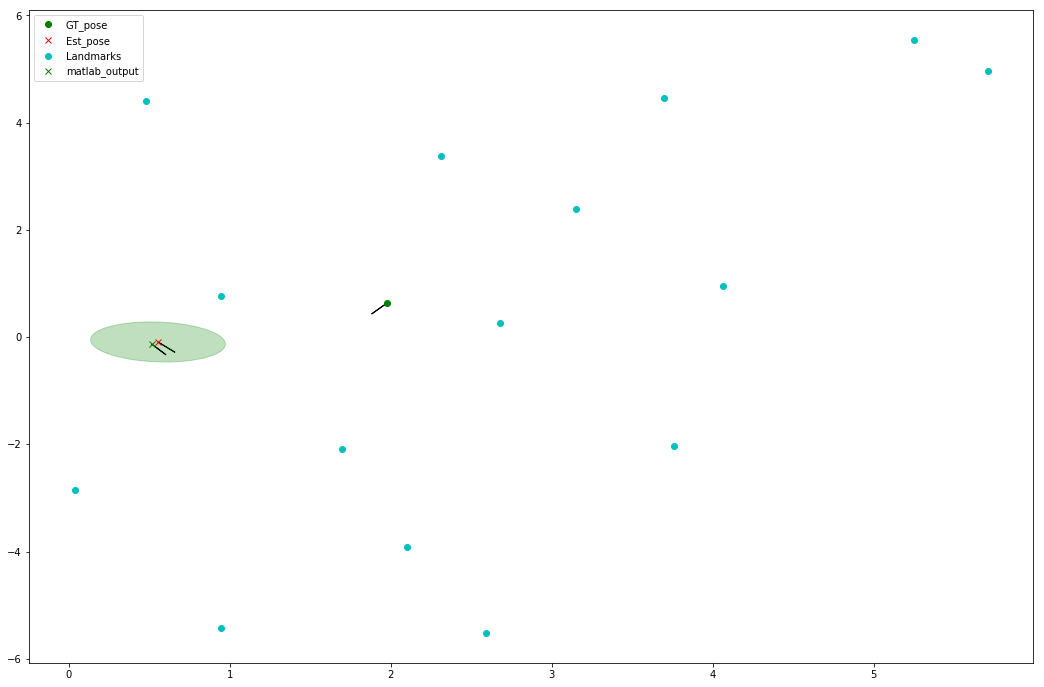

In [9]:
Robots_updated = run_filter(Robots, matlab_op_data, robot_num, plot_options)

### RMSE Error as loss function

In [10]:
print('Total deviation is ' + str(path_loss(Robots, robot_num, 10000)))

Total deviation is 186094.96315278174
